In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import numpy as np

import plotly.graph_objects as go

from rlway.pyosrd import OSRD

In [119]:
sim = OSRD(use_case='station_capacity2', dir='tmp')

[10:05:27,531] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[10:05:27,564] [INFO]              [FullInfra] parsing infra
[10:05:27,629] [INFO]              [FullInfra] adaptation to kotlin
[10:05:27,663] [INFO]              [FullInfra] loading signals
[10:05:27,669] [INFO]              [FullInfra] building blocks
[10:05:27,674] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[10:05:27,685] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.12
[10:05:27,731] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.13
[10:05:27,736] [INFO]  [StandaloneSimulationCommand] All simulations completed
[10:05:27,736] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/results.json


In [120]:
# sim=OSRD('../cases/small_infra/')

In [121]:
train = 0


In [122]:
print(sim.points_encountered_by_train(0))

[{'id': 'departure_train0', 'offset': 0.0, 'type': 'departure', 't_base': 0.0}, {'id': 'S0', 'offset': 790.0, 'type': 'signal', 't_base': 59.48809903736671}, {'id': 'D0', 'offset': 810.0, 'type': 'detector', 't_base': 60.29713485185037}, {'id': 'DVG', 'offset': 990.0, 'type': 'switch', 't_base': 67.01383110325345}, {'id': 'D1', 'offset': 1170.0, 'type': 'detector', 't_base': 73.23398546978885}, {'id': 'S1', 'offset': 1830.0, 'type': 'signal', 't_base': 93.05216588756122}, {'id': 'S3', 'offset': 2150.0, 'type': 'signal', 't_base': 101.46549700334303}, {'id': 'D3', 'offset': 2810.0, 'type': 'detector', 't_base': 118.80985648051612}, {'id': 'station', 'offset': 2820.0, 'type': 'station', 't_base': 119.08763425829389}, {'id': 'CVG', 'offset': 2990.0, 'type': 'switch', 't_base': 124.386245369405}, {'id': 'D5', 'offset': 3170.0, 'type': 'detector', 't_base': 130.30219364526707}, {'id': 'S5', 'offset': 3190.0, 'type': 'signal', 't_base': 130.99184881768088}, {'id': 'arrival_train0', 'offset':

In [123]:
self = sim
data = []
train=0
points_to_show=['switch', 'station', 'departure', 'arrival']
points = sim.points_encountered_by_train(train)

from rlway.pyosrd.osrd import Point

for i, train_id in enumerate(self.trains):
    t = [record['time'] / 60. for record in self._head_position(i)]
    offset = [
        self.offset_in_path_of_train(
            Point(
                id='',
                track_section=record['track_section'],
                type='record',
                position=record['offset']
            ),
            train
        )
        for record in self._head_position(i)
    ]
    data.append({"x":t, "y": offset, "label": train_id})

ids = [track['id'] for track in self.train_track_sections(train)]

points = {
    point['id']: point['offset']
    for point in self.points_encountered_by_train(train)
    if point['type'] in points_to_show
}

In [124]:
fig = go.Figure(
    data = [
        go.Scatter(x=t['x'], y=t['y'], name=t['label'])
        for t in data
    ],
    layout = {
        "title": 'train 0 (base)',
        "template": "simple_white",
        "xaxis_title": 'Time [min]',
        "hovermode": "x unified"
    },
)

for offset in points.values():
    fig.add_hline(
        y=offset,
        line_width=.5,
        # line_dash="dash",
        line_color="black"
    )

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [offset for offset in points.values()],
        ticktext = [p for p in points]
    )
)

fig.show()

<Axes: title={'center': 'train0 (base)'}, xlabel='Time [min]'>

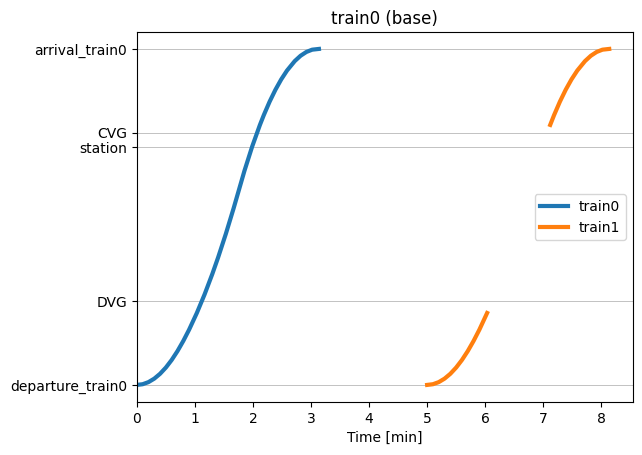

In [130]:
sim.space_time_graph(0, points_to_show=['switch', 'station', 'departure', 'arrival'])